# HW2 - Transforms!
 
In this homework we'll be practicing some data aggregations, joins, and flattening JSON files in order to make inferences from two datasets!
 
The first file is a dataset with 25,000,000 movie reviews.  These are already in flat files and are clean.  But, we obviously want to do some filtering (e.g. remove movies that only have a review or two).  And we'll want to do a couple of aggregations and joins to distill down those 25 million reviews into something understandable and useable.  
 
The other dataset will have you going to Yelp and making a dev account.  You'll then access various bits of information about local businesses and their reviews in order to figure out which ones are doing the best in Covid times.  


## Wranging and aggregating movie review data
 
The website MovieLens.com has a research group which provides open access to millions of reviews, for free!  We're going to work with those data for this homework.  [Feel free to check out the website here.](https://grouplens.org/datasets/movielens/)  You can go and download the raw data, but in order to make things a bit easier, the files have been uploaded the Google drive for fast direct downloads.  
 
There are two datasets we'll be working with.
* movies - this is a file of 60,000+ movies
* reviews - this is a file of 25 *million* individual reviews for the 60k movies
 
The goal for this section of the homework is to do two types of data aggregations that will allow for someone to make inferences on which movies were the most popular, reviewed, polarizing and were cult classics.  
 
To do this we'll first start by making a simple data set that brings just overall review properties together with movies.  We'll then do some deeper groupings to create a dataset that looks at the same properties but over time. 

### Data first
 
Let's bring in our two files and libraries.  The ratings file is understandably large.  So it's a good idea to download it and then save a copy as something else and work with that.  This way if you mess up you don't have to download it all over again


In [29]:
# Libraries
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [30]:
# Movies data
movies = pd.read_csv('https://itsa322.s3.us-east-2.amazonaws.com/movies.csv')

In [31]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [32]:
# Ratings data
ratings = pd.read_csv('https://itsa322.s3.us-east-2.amazonaws.com/ratings.csv')

In [33]:
# Make a copy of ratings; Generally, it's good practice to keep original copies saved before starting to mess with them
ratings_backup = ratings.copy

## Explore your data - [3 points]
 
Below take some time to explore your date.  
In one cell, check the following items for **both** datasets:
 
* Head and tail 
* Shape
* Datatypes

In a new cell:
* The number of NaN values for the rating column of the ratings dataset
 
**Task** Do the head,tail, and shape operations all in one cell.  Count the number of NaNs in another. 

In [34]:
# head, tail, shape of both datastes
print(movies.head())
print(movies.tail())
print(movies.shape)

print(ratings.head())
print(ratings.tail())
print(ratings.shape)


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
       movieId                           title                  genres
62418   209157                       We (2018)                   Drama
62419   209159       Window of the Soul (2001)             Documentary
62420   209163                Bad Poems (2018)            Comedy|Drama
62421   209169             A Girl Thing (2001)      (no genres listed)
62422   209171  Women of Devil's Island (1962)  Ac

In [35]:
# Get count of NaNs
print(movies.isna().sum())
print(ratings.isna().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Convert timestamp in ratings to a datetime. - [1.5 points]
 
One issue that you can see from your exploration is that the ratings only have a timestamp.  This timestamp is measured in the number of seconds since 00:00:00 on January 1st, 1970.  You'll need to convert this to a datetime in order to actually do our later data aggregations.  
 
You use `pd.to_datetime` on timestamps like this.  [For full details on the various ways to use this function please look at the Pandas documentation.](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) Briefly, this is how it's used. 
 
```
>>> pd.to_datetime(1490195805, unit='s')
Timestamp('2017-03-22 15:16:45')
```
 
**Task** Make a new column in the movies dataframe called `review_dt` that contains the data from the timestamp column but converted to a datetime datatype.  
 
Note, it's good practice to do this by first assigning the output to a test vector first, rather than directly adding the output to the dataframe. This allows you to make sure your operation did what you wanted before modifying your dataframe. Once you're confident of the output, you can assign the vector to the `reviews` dataframe as a new column. 
 
For example
```
test_vec = pd.to_datetime(arguments)
test_vec # to check what it contains
```

In [36]:
# Make test vector
test_vec = pd.to_datetime(ratings['timestamp'], unit='s')
test_vec

0          2006-05-17 15:34:04
1          2006-05-17 12:26:57
2          2006-05-17 12:27:08
3          2006-05-17 15:13:40
4          2006-05-17 12:21:50
                   ...        
25000090   2009-04-28 21:16:12
25000091   2009-04-28 20:53:18
25000092   2009-04-28 20:31:37
25000093   2009-04-28 21:17:14
25000094   2009-04-28 21:01:55
Name: timestamp, Length: 25000095, dtype: datetime64[ns]

In [10]:
# Check vector and datatype to make sure it make sense.  
test_vec.describe(datetime_is_numeric=True)


count                         25000095
mean     2008-07-09 11:04:03.121552128
min                1995-01-09 11:46:49
25%                2002-01-23 00:54:05
50%                2007-12-28 18:59:35
75%         2015-11-11 01:29:01.500000
max                2019-11-21 09:15:03
Name: timestamp, dtype: object

In [37]:
# Now ad this to the ratings dataframe
ratings['review_dt'] = test_vec

In [38]:
# Check the head of your dataframe again
ratings.head()

,userId,movieId,rating,timestamp,review_dt
0,1,296,5.0,1147880044,2006-05-17 15:34:04
1,1,306,3.5,1147868817,2006-05-17 12:26:57
2,1,307,5.0,1147868828,2006-05-17 12:27:08
3,1,665,5.0,1147878820,2006-05-17 15:13:40
4,1,899,3.5,1147868510,2006-05-17 12:21:50


In [39]:
# What's the oldest and newest review?  It should be 1995-01-09 and 2019-11-21, respectively.
# oldest_review = ratings.min()
oldest_rating = ratings[ratings['review_dt'] == ratings['review_dt'].max()]
print(f"Oldest review: {oldest_rating}")

newest_rating = ratings[ratings['review_dt'] == ratings['review_dt'].min()]
print(f"Newest review: {newest_rating}")


Oldest review:           userId  movieId  rating   timestamp           review_dt
13207877   85523   149406     4.5  1574327703 2019-11-21 09:15:03
Newest review:         userId  movieId  rating  timestamp           review_dt
326761    2262       21     3.0  789652009 1995-01-09 11:46:49
326767    2262       47     5.0  789652009 1995-01-09 11:46:49
326810    2262     1079     3.0  789652009 1995-01-09 11:46:49


## Your first aggregation and join - [4.5 points]

The first aggregation and join I want you to do is at the whole movie level.  Your movies dataframe should only have a single row for each movie, but there are obviously thousands of individual reviews for each of those movies. Our goal here is to produce some summary statistics about the reviews for each movie and then join them to the movies dataframe. 

**Task:** Do the following:
* Create an aggregated dataframe called `ratings_by_movie`. This dataframe should be grouped by movie. Use `.agg()` to calculate the mean, standard deviation ('std'), and the number of reviews for each movie.  
* Rename the columns of that dataframe `'movieId', 'rating_mean', 'rating_std', and 'rating_count'`
* Join this new `ratings_by_movie` dataframe such that it attaches all those summary statistics to their corresponding movies from the 'movies' dataframe.
* Call the joined dataframe `movies_with_ratings`

In [40]:
# Make ratings_by_movie
# ratings_by_movie = ...(..., as_index=False)....(...)
ratings_by_movie = ratings.groupby(['movieId'], as_index=False).agg({'rating': ['mean', 'std', 'count']})


In [41]:
# Check it
ratings_by_movie.head()

movieId    rating                 
               mean       std  count
0       1  3.893708  0.921552  57309
1       2  3.251527  0.959851  24228
2       3  3.142028  1.008443  11804
3       4  2.853547  1.108531   2523
4       5  3.058434  0.996611  11714

In [42]:
# Rename columns
ratings_by_movie.columns = ['movieId', 'rating_mean', 'rating_std', 'rating_count']
ratings_by_movie.head(5)

,movieId,rating_mean,rating_std,rating_count
0,1,3.893708,0.921552,57309
1,2,3.251527,0.959851,24228
2,3,3.142028,1.008443,11804
3,4,2.853547,1.108531,2523
4,5,3.058434,0.996611,11714


In [76]:
# Join it and call movies with ratings
# Example: songs_agg = songs_agg.merge(artist_info, left_on='artist_name', right_on='artist_name', how = 'left')
movies_with_ratings = movies.merge(ratings_by_movie, left_on='movieId', right_on='movieId', how='left')

In [77]:
# Check movies_with_ratings.  
movies_with_ratings.head(5)

,movieId,title,genres,rating_mean,rating_std,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,0.921552,57309.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,0.959851,24228.0
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,1.008443,11804.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,1.108531,2523.0
4,5,Father of the Bride Part II (1995),Comedy,3.058434,0.996611,11714.0


Is your merged dataframe 62423 rows × 6 columns?

In [78]:
movies_with_ratings.shape

(62423, 6)

## Filtering and more transformations - [3 points]
 
Now we want to clean up this dataset a bit and then do a couple more transforms. One issue you can see from your check above is that many movies only have one rating.  We're going to choose to set a minimum number of reviews needed to be included.  We also want to do some binning where movies with certain ratings levels 
 
**Task:** Please do the following operations
* Filter `movies_with_ratings` so it only contains movies that have at least 10 ratings
* Use the function `cut()` to automatically bin our `rating_mean` column into three groups of 'bad', 'fine', or 'good' movies.  Call this `rating_group`.
* Use the same function to take the standard deviation in rating and make three groups of 'agreement', 'average', 'controversial'.  Thus, movies with low standard deviation have agreement in the rating, while movies with high standard deviation have controversy in the ratings.  Call this column `ratings_agreement`.

In [79]:
# Filter first being sure to overwrite dataframe
movies_with_ratings = movies_with_ratings[(movies_with_ratings['rating_count'] >= 10)]
movies_with_ratings.head()

,movieId,title,genres,rating_mean,rating_std,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,0.921552,57309.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,0.959851,24228.0
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,1.008443,11804.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,1.108531,2523.0
4,5,Father of the Bride Part II (1995),Comedy,3.058434,0.996611,11714.0


In [80]:
# Check how many rows you're left with. You should have a little over 24000
movies_with_ratings.shape

(24330, 6)

I didn't show you how to use `cut()` in the lesson, but it's a transform just like anything else.  You could use a `np.where()` statement like we did, but `cut()` is a bit easier.  All it does is take 1) a column as the first argument, 2) the number of bins you want to group it in as the second argument, and then 3) the labels you want to give those bins as the third.  It automatically divides them up into equal sized bins. 
 
For example, if I make the following list:
```
rating = [2, 4, 9, 8, 5, 3, 6, 10, 2, 1, 6, 7]
```
 
And run `cut()` on it with three bins and levels 'bad', 'fine', and 'good':
```
pd.cut(rating, 3, labels=['bad', 'fine', 'good'])
```
 
I get a return of:
```
[bad, bad, good, good, fine, ..., good, bad, bad, fine, fine]
Length: 12
Categories (3, object): [bad < fine < good]
```
 
Note how it orders them for you based on the order of the labels.  

In [81]:
# If you want to test it!
rating = [2, 4, 9, 8, 5, 3, 6, 10, 2, 1, 6, 7]
pd.cut(rating, 3, labels=['bad', 'fine', 'good'])

['bad', 'bad', 'good', 'good', 'fine', ..., 'good', 'bad', 'bad', 'fine', 'fine']
Length: 12
Categories (3, object): ['bad' < 'fine' < 'good']

In [89]:
# Now make 'bad', 'fine', 'good' levels for ratings
# Assign to new column called 'rating_group'  
# ...['...'] = pd.cut(...['...'], 3, labels=['bad', 'fine', 'good'])
rating_group = pd.cut(movies_with_ratings['rating_mean'], 3, labels=['bad', 'fine', 'good'])
movies_with_ratings['rating_group'] = rating_group

In [90]:
# Check it
movies_with_ratings

,movieId,title,genres,rating_mean,rating_std,rating_count,rating_group
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,0.921552,57309.0,good
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,0.959851,24228.0,good
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,1.008443,11804.0,fine
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,1.108531,2523.0,fine
4,5,Father of the Bride Part II (1995),Comedy,3.058434,0.996611,11714.0,fine
...,...,...,...,...,...,...,...
61967,207405,Doctor Sleep (2019),Horror,3.730769,0.785109,39.0,good
62027,207612,Tell Me Who I Am (2019),Documentary,3.357143,1.099450,14.0,good
62088,207830,Terminator: Dark Fate (2019),Action|Sci-Fi,3.372727,0.794764,55.0,good
62313,208715,Let It Snow (2019),Comedy|Romance,2.933333,1.222799,15.0,fine


Do Toy Story and Jumanji have 'good' ratings?  Does Grumpier Old Men have a 'fair' rating?

In [91]:
# Now use cut() again to create your ratings_agreement column.  
# Use three bins and order of 'agreement', 'average',  and 'controversial'

movies_with_ratings.head()
ratings_agreement = pd.cut(movies_with_ratings['rating_mean'], 3, labels=['agreement', 'average', 'controversial'])
movies_with_ratings['ratings_agreement'] = ratings_agreement

In [92]:
# Check to make sure that your bin categories make sense. e.g. 'good' movies should have higher ratings than 'fine', 'controversial' movies should ... ?
movies_with_ratings.head()
# Interesting trivia, at least to me, Jumanji was made in my home state and filmed about 40 miles from where I grew up.

,movieId,title,genres,rating_mean,rating_std,rating_count,rating_group,ratings_agreement
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,0.921552,57309.0,good,controversial
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,0.959851,24228.0,good,controversial
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,1.008443,11804.0,fine,average
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,1.108531,2523.0,fine,average
4,5,Father of the Bride Part II (1995),Comedy,3.058434,0.996611,11714.0,fine,average


###  Exploring our data 
 
Making bins like this allows us to figure out things like which movies are both bad, but have differing opinions on.  For example, we can filter out movies that are in the bad category but have a lot of controversy about those ratings.  This could mean they're 'cult classic' movies where despite the low rating some people actually really love the movies.  
 
A dataset like this could be used in a recommendation engine where if you see people liking these 'bad but good' movies you could suggest others that meet the came criteria.  

**Task:** There are no points here - only code to let you make figures to see what the dataset could be used for. Also, if this code works it means you probably did your answers above are right :)

In [93]:
bad_but_good = movies_with_ratings[(movies_with_ratings['rating_group'] == 'bad') & 
                    (movies_with_ratings['ratings_agreement'] == 'controversial') & 
                    (movies_with_ratings['rating_count'] >= 100)]
bad_but_good.head()

,movieId,title,genres,rating_mean,rating_std,rating_count,rating_group,ratings_agreement


Birdemic: Shock and Terror :D - I think I would prefer a Birdemic to a pandemic!

## Grouping within years - [3 point]
 
Now that we've done our overall grouping by movie, let's get a bit more detail about these ratings. Specifically, let's engineer a dataset that breaks down the average rating not only by movie, but also by the year the person provided the review.  This would allow for someone to see which movies continue to do well over time, which ones become more popular, and which ones don't age well!
 
**Task:** You're going to do the following steps:
* Create a new `ratings_by_movie` that groups both by `movieId` but also by your `review_dt` column.  I want you to group into year intervals.  
* Join `movies` to `ratings_by_movie` so that you have the summary review statistics for each year the movie has been out
* Clean up and filter your dataframe

First, create `ratings_by_movie`.  You can group by two levels by just adding a list of what levels you want to group by in the `groupby()` statement.  I'll give you some help there, but you have to complete the rest in order to group by movieId first and review_dt second. 

In [94]:
# Note the groupby syntax.  I first am grouping by movieId
# But then also am calling dt.year on our datetime column
# This will then tell Python to do the aggregations within year as well
# ... = .......(['...', ratings['review_dt'].dt.year]).agg(...)
ratings_by_movie = ratings.groupby([ratings['movieId'], ratings['review_dt'].dt.year]).agg({'rating': ['mean', 'std', 'count']})

In [95]:
# Check
ratings_by_movie

rating                
                       mean       std count
movieId review_dt                          
1       1996       4.132756  0.884990  6237
        1997       3.872500  0.894079  6000
        1998       3.889515  0.944972   887
        1999       3.975140  0.913960  2494
        2000       4.136634  0.865127  3535
...                     ...       ...   ...
209157  2019       1.500000       NaN     1
209159  2019       3.000000       NaN     1
209163  2019       4.500000       NaN     1
209169  2019       3.000000       NaN     1
209171  2019       3.000000       NaN     1

[323737 rows x 3 columns]

You need to rename columns, but this is a bit trickier as you have two levels of your dataframe index. I'm going to give you the code below.  But, what it's doing is resetting that one level of the index `review_dt` and putting it back as a regular column.  I'm then renaming the resulting columns. 

In [96]:
# Reset index
ratings_by_movie = ratings_by_movie.reset_index(level = 'review_dt')
ratings_by_movie.columns = ['year', 'rating_mean', 'rating_std', 'rating_count']
ratings_by_movie

,year,rating_mean,rating_std,rating_count
movieId,,,,
1,1996,4.132756,0.884990,6237
1,1997,3.872500,0.894079,6000
1,1998,3.889515,0.944972,887
1,1999,3.975140,0.913960,2494
1,2000,4.136634,0.865127,3535
...,...,...,...,...
209157,2019,1.500000,NaN,1
209159,2019,3.000000,NaN,1
209163,2019,4.500000,NaN,1


In [97]:
# Now join the movie dataframe onto ratings_by_movie
# Example from above: movies_with_ratings = movies.merge(ratings_by_movie, left_on='movieId', right_on='movieId', how='left')
ratings_by_movie = movies.merge(ratings_by_movie, left_on='movieId', right_on='movieId', how='left')

In [98]:
# Check
ratings_by_movie.head()

,movieId,title,genres,year,rating_mean,rating_std,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1996.0,4.132756,0.884990,6237.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1997.0,3.872500,0.894079,6000.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1998.0,3.889515,0.944972,887.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1999.0,3.975140,0.913960,2494.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000.0,4.136634,0.865127,3535.0


In [99]:
# How many rows are there in the resulting dataframe?
ratings_by_movie.shape
# 327113 rows

(327113, 7)

In your dataframe do you see Toy Story having a mean rating of 4.132756 in 1996?  Is your dataframe 323737 rows × 7 columns?

Yes, mine matches.

### A quick plot

Now you have a dataset where one could explore how movies have done over time. I've made a couple plots below to show you want I mean.

In [100]:
# What movie has the max rating?
movies_with_ratings.loc[movies_with_ratings['rating_count'] == movies_with_ratings['rating_count'].max()]

,movieId,title,genres,rating_mean,rating_std,rating_count,rating_group,ratings_agreement
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.048011,0.93881,81491.0,good,controversial


In [101]:
# Grabbing just the ID for that movie. 
movies_with_ratings['movieId'][movies_with_ratings['rating_count'] == movies_with_ratings['rating_count'].max()].values[0]

356

In [102]:
# Forest gump has been reviewed over 80000 times!  
# Let's extract that movie id to an object and then make just that dataframe
most_viewed_id = movies_with_ratings['movieId'][movies_with_ratings['rating_count'] == movies_with_ratings['rating_count'].max()].values[0]

most_viewed_df = ratings_by_movie[ratings_by_movie['movieId'] == most_viewed_id]
most_viewed_df

,movieId,title,genres,year,rating_mean,rating_std,rating_count
7927,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1996.0,4.120873,0.931022,15264.0
7928,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1997.0,4.085352,0.919867,1816.0
7929,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1998.0,4.093245,1.046018,1051.0
7930,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1999.0,3.787516,1.163514,3172.0
7931,356,Forrest Gump (1994),Comedy|Drama|Romance|War,2000.0,4.027959,1.051722,3827.0
7932,356,Forrest Gump (1994),Comedy|Drama|Romance|War,2001.0,4.119985,0.993906,2667.0
7933,356,Forrest Gump (1994),Comedy|Drama|Romance|War,2002.0,3.981262,1.014716,1601.0
7934,356,Forrest Gump (1994),Comedy|Drama|Romance|War,2003.0,3.973144,0.973239,1657.0
7935,356,Forrest Gump (1994),Comedy|Drama|Romance|War,2004.0,3.878659,0.951275,2596.0
7936,356,Forrest Gump (1994),Comedy|Drama|Romance|War,2005.0,3.834838,0.953641,3987.0


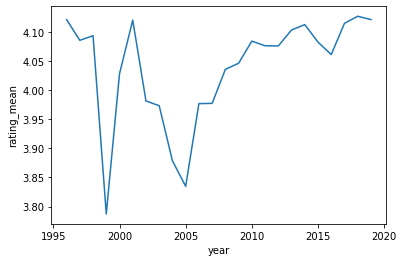

In [103]:
#  A quick lineplot shows that although forest gump has a really high rating on average, it seems to have some bad years for some reason.
sns.lineplot(data = most_viewed_df, x = 'year', y = 'rating_mean')

You can also look up some of your favorite movies.  I actually love the movie 'Dredd', even though many people hated it.  We can search in the titles for movies we like, and then call that ID to filter a new dataframe.  We can then make some plots

In [104]:
# Search for Dredd
# Dredd is so bad, it is good.  I too am a fan.
# Prometheus, technically a really bad movie.  I have watched it at least 6 times. :-)
movies_with_ratings[movies_with_ratings['title'].str.contains('Dredd')]

,movieId,title,genres,rating_mean,rating_std,rating_count,rating_group,ratings_agreement
171,173,Judge Dredd (1995),Action|Crime|Sci-Fi,2.555360,1.039140,14758.0,fine,average
18491,96737,Dredd (2012),Action|Sci-Fi,3.569671,0.981699,3495.0,good,controversial


In [105]:
# Call the dredd to make a dataframe
dredd_id = movies_with_ratings['movieId'][movies_with_ratings['title'].str.contains('^Dredd')].values[0]
dredd_df = ratings_by_movie[ratings_by_movie['movieId'] == dredd_id]
dredd_df

,movieId,title,genres,year,rating_mean,rating_std,rating_count
226347,96737,Dredd (2012),Action|Sci-Fi,2012.0,3.707317,0.702514,82.0
226348,96737,Dredd (2012),Action|Sci-Fi,2013.0,3.456989,0.832099,279.0
226349,96737,Dredd (2012),Action|Sci-Fi,2014.0,3.496667,0.947439,150.0
226350,96737,Dredd (2012),Action|Sci-Fi,2015.0,3.543118,1.017194,603.0
226351,96737,Dredd (2012),Action|Sci-Fi,2016.0,3.576220,1.004333,656.0
226352,96737,Dredd (2012),Action|Sci-Fi,2017.0,3.552011,1.030304,721.0
226353,96737,Dredd (2012),Action|Sci-Fi,2018.0,3.571839,0.964888,522.0
226354,96737,Dredd (2012),Action|Sci-Fi,2019.0,3.682573,0.973061,482.0


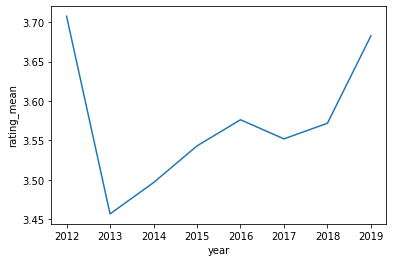

In [106]:
# Our plot shows that the year after release it was reviewed pretty poorly, 
# but the score gradually grew as people realized how awesome it was :)
sns.lineplot(x = 'year', y = 'rating_mean', data = dredd_df)

## Flatting JSON data from Yelp
 
For this second part of the assignment we're going to be using the Yelp API via the python package `yelpapi`.  Like with the Spotify API, you need to go get a yelp developer account here: https://www.yelp.com/fusion. 
When you try to create an app, it asks for name, description and contact info. The it gives you clientid and api key. 
 
The goal will be to make a dataset of local taco places that are doing well during Coronavirus. Specifically, we want to make a dataset that takes their average score since they've been open and compares it to the average score of the last three reviews.  Shops that have been doing well should hopefully have these two averages be similar. 
 
There will be three main steps to this process:
 
* First you'll search by location type and get aggregate information for everything that falls in the ice cream category.
* Second you'll get reviews for all those locations.  Yelp only returns three reviews when you call an ID, but that still works. Given you can only query one ID at a time, you'll need to write a loop to create a dataframe of all the reviews.  
* Third, you'll aggregate the latest review information to see how their average review score compares to their overall average review score.  

In [107]:
# Mount google drive
import os, sys
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [108]:
# Install yelpapi once. Tomorrow, you can skip this.
!pip install --target=$nb_path yelpapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 161 kB 10.9 MB/s 
     |████████████████████████████████| 61 kB 115 kB/s 
     |████████████████████████████████| 140 kB 36.6 MB/s 


In [109]:
# Now enter your API key so you can make requests
from yelpapi import YelpAPI
from pandas.io.json import json_normalize
# yelp_api = YelpAPI('ENTER YOUR KEY HERE')
"""
Yelp:
client id: ZDxy7f5b7NxwDdo7_T4TCg
api key: Wozh1kzMBWNj_Sdlofi5xHjaKFwl8CXLPhObgmxzMHdatl6ERmlUsDP2F7kWIlbwRp2ddfU3Tka1gTsVyTr4usFFsgEGTc_pnVoNMS-ZVo4oEw1DuNvS-1Qirb4wY3Yx
"""
api_key = 'Wozh1kzMBWNj_Sdlofi5xHjaKFwl8CXLPhObgmxzMHdatl6ERmlUsDP2F7kWIlbwRp2ddfU3Tka1gTsVyTr4usFFsgEGTc_pnVoNMS-ZVo4oEw1DuNvS-1Qirb4wY3Yx'
yelp_api = YelpAPI(api_key)


### Making calls to with Yelp API

There are many functions in the `yelpapi` package.  The first one we'll use is `search_query()`.  You can put in a term you want to search for followed up by the location and it'll give you all the locations that match.  For example, the following would search for all ice cream places here in Tucson.

```
ice = yelp_api.search_query(term = 'ice cream', location = 'Tucson, AZ')
```

This will give you a response of all the ice cream places in Tucson. It'll be in JSON form so will need flattening before being useful. 

### Getting all taco shops and flattening - [3 points]

**Task:** Start by making a dataframe that uses the `search_query()` function to search using the term 'taco'.  Call this `taco_shops`.  After that, flatten the json results to `taco_shops_df`. 

In [110]:
# search for taco shops and store to taco_shops
taco_shops = yelp_api.search_query(term='taco',  location='Tucson, AZ')

In [111]:
# Look at taco_shops
taco_shops

{'businesses': [{'id': 'jmwasbZfgj3honf79qKsnA',
   'alias': 'street-taco-and-beer-co-tucson',
   'name': 'Street- Taco and Beer Co.',
   'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/VOaRTnYRNSnSF6DR28fUog/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/street-taco-and-beer-co-tucson?adjust_creative=ZDxy7f5b7NxwDdo7_T4TCg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=ZDxy7f5b7NxwDdo7_T4TCg',
   'review_count': 871,
   'categories': [{'alias': 'mexican', 'title': 'Mexican'},
    {'alias': 'bars', 'title': 'Bars'}],
   'rating': 4.5,
   'coordinates': {'latitude': 32.222001, 'longitude': -110.972225},
   'transactions': ['delivery'],
   'price': '$',
   'location': {'address1': '58 W Congress St',
    'address2': None,
    'address3': '',
    'city': 'Tucson',
    'zip_code': '85701',
    'country': 'US',
    'state': 'AZ',
    'display_address': ['58 W Congress St', 'Tucson, AZ 85701']},
   'phone': '+15202696266',
   'display_phone': 

In [112]:
# What keys are present?
taco_shops.keys()

dict_keys(['businesses', 'total', 'region'])

Now use the json_normalize function to flatten `taco_shops`.  Note that you need to select the key that contains the businesses when flattening.  But this one is easier than the examples from the homework in that you don't need to provide any other arguments.  
 
Store the result as `taco_shops_df`
 
After that select only the columns 'id', 'alias', 'name', 'review_count', and 'rating'.

In [113]:
# Flatten to taco_shops_df
taco_shops_df = pd.json_normalize(taco_shops['businesses'])
taco_shops_df.head() # Check

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address
0,jmwasbZfgj3honf79qKsnA,street-taco-and-beer-co-tucson,Street- Taco and Beer Co.,https://s3-media4.fl.yelpcdn.com/bphoto/VOaRTn...,False,https://www.yelp.com/biz/street-taco-and-beer-...,871,"[{'alias': 'mexican', 'title': 'Mexican'}, {'a...",4.5,[delivery],...,32.222001,-110.972225,58 W Congress St,None,,Tucson,85701,US,AZ,"[58 W Congress St, Tucson, AZ 85701]"
1,o3woQWQ-0HxFftItIEeNdw,el-rustico-tucson,El Rustico,https://s3-media1.fl.yelpcdn.com/bphoto/lWPIqw...,False,https://www.yelp.com/biz/el-rustico-tucson?adj...,171,"[{'alias': 'tacos', 'title': 'Tacos'}]",4.5,[],...,32.249041,-110.978552,2281 N Oracle Rd,,None,Tucson,85705,US,AZ,"[2281 N Oracle Rd, Tucson, AZ 85705]"
2,Nggy_QUDxaLlrcQAQf7GnQ,taqueria-juanitos-tucson-4,Taqueria Juanito's,https://s3-media1.fl.yelpcdn.com/bphoto/9dwZ5q...,False,https://www.yelp.com/biz/taqueria-juanitos-tuc...,428,"[{'alias': 'mexican', 'title': 'Mexican'}]",4.5,"[pickup, delivery]",...,32.250571,-110.982543,708 W Grant Rd,,,Tucson,85705,US,AZ,"[708 W Grant Rd, Tucson, AZ 85705]"
3,A-5IN85MwL9F8wJRsDna6g,tacos-apson-tucson,Tacos Apson,https://s3-media2.fl.yelpcdn.com/bphoto/3fm1Nq...,False,https://www.yelp.com/biz/tacos-apson-tucson?ad...,266,"[{'alias': 'mexican', 'title': 'Mexican'}]",4.5,[],...,32.183140,-110.976883,3501 S 12th Ave,,,Tucson,85713,US,AZ,"[3501 S 12th Ave, Tucson, AZ 85713]"
4,nEaTbGFlU7d9eLU2kl6KBw,taqueria-el-pueblito-tucson-2,Taqueria El Pueblito,https://s3-media2.fl.yelpcdn.com/bphoto/DNlNjV...,False,https://www.yelp.com/biz/taqueria-el-pueblito-...,372,"[{'alias': 'mexican', 'title': 'Mexican'}, {'a...",4.0,"[pickup, delivery]",...,32.264046,-110.944400,1800 E Fort Lowell Rd,Ste A156,,Tucson,85719,US,AZ,"[1800 E Fort Lowell Rd, Ste A156, Tucson, AZ 8..."


In [114]:
# Select only necessary columns
# ... = ....[['...', '...', ...]]
taco_shops_df = taco_shops_df[['id', 'alias', 'name', 'review_count', 'rating']]
taco_shops_df.shape # Check shape.  Is it 20 x 5?

(20, 5)

## Getting reviews for the taco shops - [6 points]
 
Now we're going to use the `reviews_query()` function to get the last three reviews for a given ID.  The issue here is that you can only feed it one ID at a time.  So, we'll have to write a loop that queries for each ID in `taco_shops_df` and builds out a dataframe of reviews.  

**Task:**  Write a for loop that does the following steps:
* First make an empty data frame outside of the loop called `taco_shops_reviews_df`
* Initalize your loop so that it runs the length of `taco_shops_df` you made earlier.
* For each i in loop, use the id from `taco_shops_df` to get reviews from yelp using the `reviews_query()` function in `yelp_api` and store it to an object called `reviews`.
* Flatten `reviews` to an objected called `reviews_df`
* Add `location_id` to `reviews_df` - I gave you the code to do this :)
* Append `reviews_df` to `taco_shops_reviews_df` such that it builds out that dataframe with each `reviews_df` dataframe that's generated each loop.
* After the loop is done select only the columns `'id', 'text', 'rating', 'time_created', 'location_id'`

In [115]:
# Write our loop
taco_shop_reviews_df = pd.DataFrame()

for i in range(len(taco_shops_df)):
  reviews = yelp_api.reviews_query(taco_shops_df['id'][i])
  reviews_df = pd.json_normalize(reviews['reviews'])
  reviews_df['location_id'] = taco_shops_df['id'][i]
  taco_shop_reviews_df = taco_shop_reviews_df.append(reviews_df)


In [116]:
# Select columns 'id', 'text', 'rating', 'time_created', 'location_id'
taco_shop_reviews_df = taco_shop_reviews_df[['id', 'text', 'rating', 'time_created', 'location_id']]
taco_shop_reviews_df.head()

,id,text,rating,time_created,location_id
0,OddPiUmShngB2Rj8JWXwFA,I went here on a trip and great tacos for ever...,5,2022-09-06 21:18:24,jmwasbZfgj3honf79qKsnA
1,x9UJfmFWcguwBf-ZVcK5Gg,"Friendly staff, tasty grub. Nachos and Al past...",5,2022-08-27 17:53:52,jmwasbZfgj3honf79qKsnA
2,L1OUEPryT_GQs-Z46DoJKA,Their Sonoran dogs are delicious! The churros ...,5,2022-09-17 18:05:18,jmwasbZfgj3honf79qKsnA
0,q6kk29gZAkaEi2DYH437oQ,We stopped in here after a tip and quick Yelp ...,5,2022-09-12 10:34:38,o3woQWQ-0HxFftItIEeNdw
1,KYZCsgN99wkxG09E9aGUSw,Very solid place and I very well could bump th...,4,2022-09-08 16:17:26,o3woQWQ-0HxFftItIEeNdw


### Aggregating your review data - [3 points]
 
**Task:** Now go and do a data aggregation to get the mean review score across the three reviews. Remember, we want this grouped by location_id.  Call this dataframe `latest_reviews_agg`.
 
In your groupby you should set `as_index` to false to make joining on the ID values easier.
 
You should also rename the second column to `rating_mean` vs. leaving it as the dual level name. 


In [117]:
# Do your groupby to get mean rating. 
# Call it latest_reviews_agg.
# ... = ...(..., as_index=False).....
# example from above: ratings_by_movie = ratings.groupby(['movieId'], as_index=False).agg({'rating': ['mean', 'std', 'count']})

latest_reviews_agg = taco_shop_reviews_df.groupby(['location_id'], as_index=False).agg({'rating': ['mean']})


In [118]:
# Check it! 
latest_reviews_agg.head()

,location_id,rating
,,mean
0,0Q_A1mtkXkovpuqgyT1BtA,5.000000
1,0ghzROkZWKWwQKDt1fkPAQ,4.666667
2,4r6N_Fhiwoqo_FqQ7Mm6mQ,2.333333
3,A-5IN85MwL9F8wJRsDna6g,2.333333
4,AVBqx8FaXza6x-bb_FLOTQ,3.666667


In [119]:
# Rename so the two column names are 'location_id' and 'mean_rating'
latest_reviews_agg.columns = ['location_id', 'mean_rating']
latest_reviews_agg

,location_id,mean_rating
0,0Q_A1mtkXkovpuqgyT1BtA,5.000000
1,0ghzROkZWKWwQKDt1fkPAQ,4.666667
2,4r6N_Fhiwoqo_FqQ7Mm6mQ,2.333333
3,A-5IN85MwL9F8wJRsDna6g,2.333333
4,AVBqx8FaXza6x-bb_FLOTQ,3.666667
5,JFteGsQlrJeJjur6cA1RhA,4.000000
6,LQcGL4hfJAeK6bk2ZdhmXw,4.666667
7,MK0OMY_u9unl8xSqjPLtMw,3.333333
8,Nggy_QUDxaLlrcQAQf7GnQ,4.666667
9,SjjrTfCxmLp0kJgy62sRAg,5.000000


### Join your two datasets and one last transform - [3 points]
 
**Task:** Now it's time to join `latest_reviews_agg` back to your `taco_shops_df` dataframe.  You're going to want to join them on the location_id, but remember it is called just 'id' in the `taco_shops_df`  dataframe.  Call this joined dataset `taco_shops_comp` 
 
After you make that dataset do one last transform.  In this I want you to make a new column called 'still_good' where the value is 'yes' if the mean_rating is greater than or equal to the average rating since they opened, or 'no' if the rating has dropped.   The idea here is that this could be a value that one would use to see if their average score of the latest reviews has improved or suffered during Covid.  

In [120]:
# Join and name taco_shops_comp
taco_shops_comp = latest_reviews_agg.merge(taco_shops_df, left_on='location_id', right_on='id', how='left')
taco_shops_comp.head()

,location_id,mean_rating,id,alias,name,review_count,rating
0,0Q_A1mtkXkovpuqgyT1BtA,5.000000,0Q_A1mtkXkovpuqgyT1BtA,taqueria-rosita-tucson,Taqueria Rosita,30,5.0
1,0ghzROkZWKWwQKDt1fkPAQ,4.666667,0ghzROkZWKWwQKDt1fkPAQ,el-guero-canelo-tucson-7,El Guero Canelo,719,4.0
2,4r6N_Fhiwoqo_FqQ7Mm6mQ,2.333333,4r6N_Fhiwoqo_FqQ7Mm6mQ,boca-by-chef-maria-mazon-tucson,BOCA by Chef Maria Mazon,831,3.5
3,A-5IN85MwL9F8wJRsDna6g,2.333333,A-5IN85MwL9F8wJRsDna6g,tacos-apson-tucson,Tacos Apson,266,4.5
4,AVBqx8FaXza6x-bb_FLOTQ,3.666667,AVBqx8FaXza6x-bb_FLOTQ,anita-street-market-tucson,Anita Street Market,188,4.5


In [121]:
# Make still_good column
taco_shops_comp.loc[taco_shops_comp['mean_rating'] >= taco_shops_comp['rating'], 'still_good'] = 'yes'
taco_shops_comp.loc[taco_shops_comp['mean_rating'] < taco_shops_comp['rating'], 'still_good'] = 'no'
taco_shops_comp.head()

,location_id,mean_rating,id,alias,name,review_count,rating,still_good
0,0Q_A1mtkXkovpuqgyT1BtA,5.000000,0Q_A1mtkXkovpuqgyT1BtA,taqueria-rosita-tucson,Taqueria Rosita,30,5.0,yes
1,0ghzROkZWKWwQKDt1fkPAQ,4.666667,0ghzROkZWKWwQKDt1fkPAQ,el-guero-canelo-tucson-7,El Guero Canelo,719,4.0,yes
2,4r6N_Fhiwoqo_FqQ7Mm6mQ,2.333333,4r6N_Fhiwoqo_FqQ7Mm6mQ,boca-by-chef-maria-mazon-tucson,BOCA by Chef Maria Mazon,831,3.5,no
3,A-5IN85MwL9F8wJRsDna6g,2.333333,A-5IN85MwL9F8wJRsDna6g,tacos-apson-tucson,Tacos Apson,266,4.5,no
4,AVBqx8FaXza6x-bb_FLOTQ,3.666667,AVBqx8FaXza6x-bb_FLOTQ,anita-street-market-tucson,Anita Street Market,188,4.5,no


In [123]:
# So, do any locations have a lower average in their last three reviews compared to their average overall score?
lower_ratings = taco_shops_comp[(taco_shops_comp['still_good'] == 'no')]
print(f"There are {len(lower_ratings)} taco shops with lower ratings.")

There are 9 taco shops with lower ratings.
